# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Define file locations and read data

In [8]:
WORKING_DIR = 'd:\\David\\endoderm_migration\\raw_data\\2025_01_22_2DFACS_FOXA2positive_lateday2' # example: 'd:\\David\\endoderm_migration\\2024_09_09_FoxA2_tdTom_c211to300_BmpAct_day2To3'
BRIGHTFIELD_IMAGES_FOLDER = WORKING_DIR+'\\brightfield'
TRACKS_FOLDER = WORKING_DIR+'\\manual_tracks'

## pixel size

In [9]:
# pixel size in microns to convert the pixel coordinates to microns
pixel_size = 0.32 # microns

# Tracks

In [17]:
# Initialize an empty DataFrame
raw_df = pd.DataFrame()

# Loop through each file in the specified folder
for filename in os.listdir(TRACKS_FOLDER):
    if filename.endswith(".csv"):
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(os.path.join(TRACKS_FOLDER, filename))
        
        # Add a new column with the filename to keep track of the source of each row
        temp_df['file'] = filename
        
        # Concatenate with the main DataFrame
        raw_df = pd.concat([raw_df, temp_df], ignore_index=True)

# change the column names to fit the rest of the code
raw_df = raw_df.rename(columns={'tracks_number': 'ID', 'frame': 't', 'X': 'x_pixels', 'Y': 'y_pixels'})

## Creating df

In [14]:
dt = 5 # time interval between frames in minutes

In [19]:
# create a DataFrame with all the coordinates and track IDs
tracks_df = raw_df[['file', 'ID', 't', 'x_pixels', 'y_pixels']].copy()

# calculate the normalized time for each track
tracks_df['t'] = tracks_df['t'] * dt # convert to actual time using dt
tracks_df['normalized_time'] = tracks_df.groupby(['ID','file'])['t'].transform(lambda x: x - x.min())
tracks_df['step'] = tracks_df['normalized_time']// dt

tracks_df.reset_index(drop=True, inplace=True)

# combine file and ID to create a unique track ID
tracks_df['track_id'] = tracks_df['file'] + '_' + tracks_df['ID'].astype(str)

# get position (pattern position from the file name)
tracks_df['position'] = tracks_df['file'].str.split('xy').str[1].str.split('.').str[0]

for i, row in tracks_df.iterrows():
    image_id = row['file'].split('_')[1].split('.')[0]
    
    x = int(row['x_pixels'])
    y = int(row['y_pixels'])

# convert units to microns
tracks_df['x_microns'] = tracks_df['x_pixels'] * pixel_size
tracks_df['y_microns'] = tracks_df['y_pixels'] * pixel_size

# reorganize the DataFrame
tracks_df = tracks_df[['file', 'position','ID', 'track_id', 't', 'normalized_time', 'step', 'x_pixels', 'y_pixels', 'x_microns', 'y_microns']]

tracks_df.head()

,file,position,ID,track_id,t,normalized_time,step,x_pixels,y_pixels,x_microns,y_microns
0,manual_tracks_xy01.csv,01,1,manual_tracks_xy01.csv_1,5,0,0,418,1130,133.76,361.60
1,manual_tracks_xy01.csv,01,1,manual_tracks_xy01.csv_1,10,5,1,430,1130,137.60,361.60
2,manual_tracks_xy01.csv,01,1,manual_tracks_xy01.csv_1,15,10,2,432,1124,138.24,359.68
3,manual_tracks_xy01.csv,01,1,manual_tracks_xy01.csv_1,20,15,3,432,1120,138.24,358.40
4,manual_tracks_xy01.csv,01,1,manual_tracks_xy01.csv_1,25,20,4,432,1120,138.24,358.40


In [20]:
# save the DataFrame to a csv file
save_to = r'D:\David\THESIS\tracks_dataframes'
tracks_df.to_csv(save_to+f'\\manual_tracks_df_{WORKING_DIR.split("\\")[-1]}.csv', index=False)

# Cell Counts

Text(0.5, 1.0, 'Cell Counts Per Timepoint')

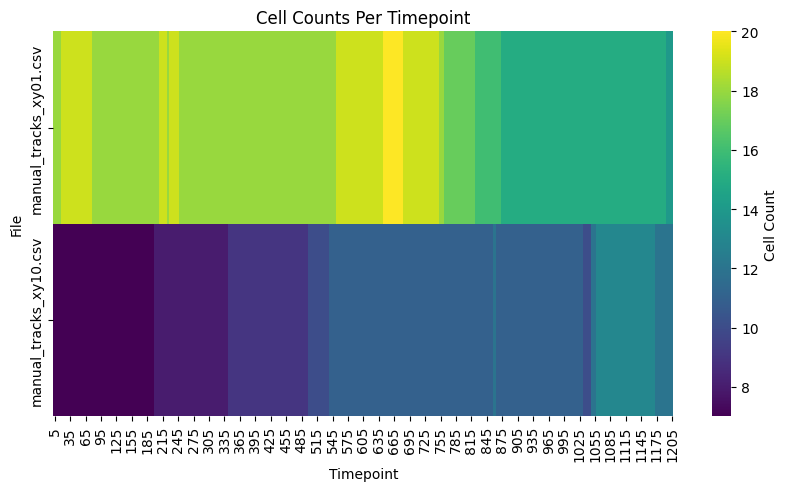

In [21]:
# create a df with cell counts per timepoint (rows: timepoints, columns: file, values: cell counts)
cell_counts = tracks_df.groupby(['file', 't']).size().unstack().fillna(0)

# plot the cell counts per timepoint
plt.figure(figsize=(10, 5))
sns.heatmap(cell_counts, cmap='viridis', cbar_kws={'label': 'Cell Count'})
plt.xlabel('Timepoint')
plt.ylabel('File')
plt.title('Cell Counts Per Timepoint')